In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/cars-2022-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cars-2022-dataset/CARS_1.csv


In [2]:
cars = pd.read_csv("/kaggle/input/cars-2022-dataset/CARS_1.csv")

In [3]:
cars.dtypes

car_name                object
reviews_count            int64
fuel_type               object
engine_displacement      int64
no_cylinder              int64
seating_capacity       float64
transmission_type       object
fuel_tank_capacity     float64
body_type               object
rating                 float64
starting_price           int64
ending_price             int64
max_torque_nm          float64
max_torque_rpm           int64
max_power_bhp          float64
max_power_rp             int64
dtype: object

know the data types of the features so can perform the computation on numerical featuers

In [4]:
features = ["reviews_count", "engine_displacement", "no_cylinder",
            "seating_capacity", "fuel_tank_capacity", "rating",
            "starting_price", "ending_price", "max_torque_nm", 
            "max_torque_rpm", "max_power_bhp", "max_power_rp"]

In [5]:
X = cars[features].dropna()

In [6]:
print(X.index)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202],
      dtype='int64', length=202)


In [7]:
classes = cars.loc[X.index, "body_type"]

Keep the body_type column for coloring in PCA plots.

In [8]:
X_standardized = (X - X.mean()) / X.std()

Apply Z-score normalization so each feature has mean = 0 and standard deviation = 1.

This ensures no feature dominates PCA due to scale differences.

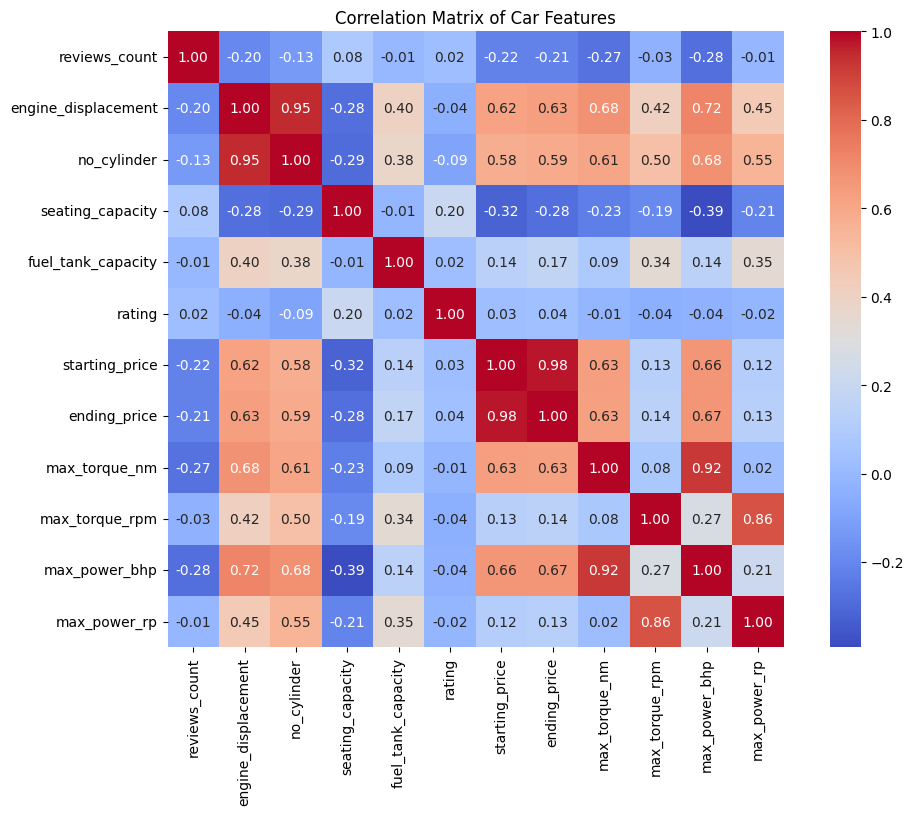

In [9]:
corr_df = X_standardized.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)
plt.title("Correlation Matrix of Car Features")
plt.show()

The correlation matrix shows pairwise linear relationships between features, normalized to a range of -1 to 1.

Since the data is standardized, this correlation matrix is effectively the same as the covariance matrix.

Interpretation:

Values near +1 → features increase together.

Values near -1 → as one increases, the other decreases.

Values near 0 → weak or no linear relationship.

Including this visualization helps confirm why PCA will combine some features strongly in PC1 and PC2.

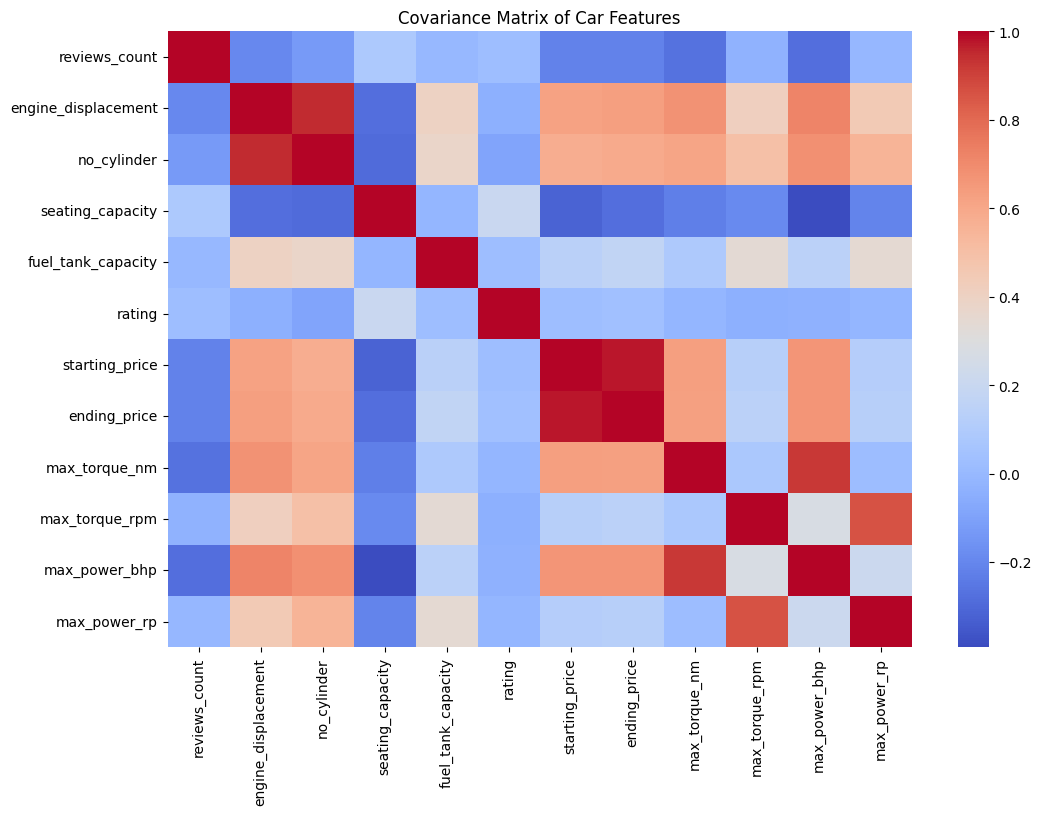

In [10]:
cov_matrix = np.cov(X_standardized.T)

plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(cov_matrix, index=features, columns=features),
            annot=False, cmap="coolwarm")
plt.title("Covariance Matrix of Car Features")
plt.show()


Compute the covariance matrix of standardized data.

Visualize relationships between features.

Because the data is standardized, this matrix is numerically the same as a correlation matrix.

In [11]:
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort by variance explained
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_idx]
eigenvectors = eigenvectors[:, sorted_idx]

Solve the eigenvalue problem:
$$
Σ
𝑣
= 
𝜆
𝑣
$$

Sort eigenvalues in descending order so the most important PCs come first.

Eigenvectors define new PCA axes; Eigenvalues show how much variance they explain.



PC1: 42.61% of variance explained
PC2: 16.98% of variance explained
PC3: 9.74% of variance explained
PC4: 7.69% of variance explained
PC5: 7.08% of variance explained
PC6: 5.82% of variance explained
PC7: 5.13% of variance explained
PC8: 3.04% of variance explained
PC9: 0.99% of variance explained
PC10: 0.41% of variance explained
PC11: 0.33% of variance explained
PC12: 0.18% of variance explained


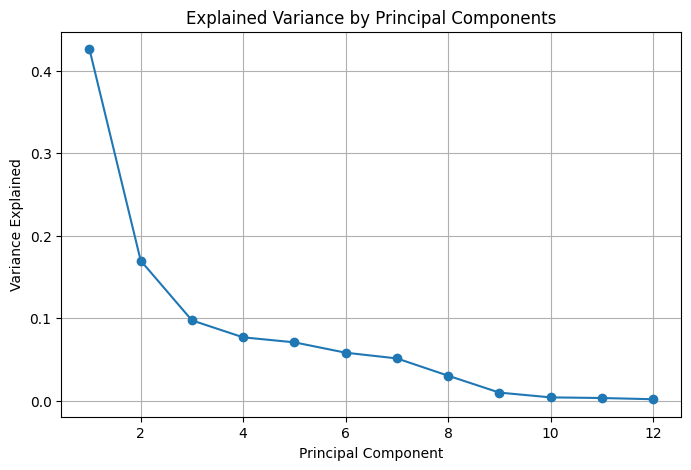

In [12]:
# Explained variance
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.2%} of variance explained")

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()


Calculate the fraction of total variance each PC explains:

$$
Explained\ Variance\ Ratio_i = \frac{\lambda_i}{\sum_{j}\lambda_j}
$$

Use a scree plot to check how many PCs are worth keeping.

Typically, PC1 + PC2 explain the majority of variance.

In [13]:
pc_vectors = eigenvectors[:, :2]
X_pca = np.dot(X_standardized, pc_vectors)

Select the top 2 eigenvectors.

Multiply the standardized data by them to compute new coordinates (PC1 & PC2).

Each car now has a position in PCA space.

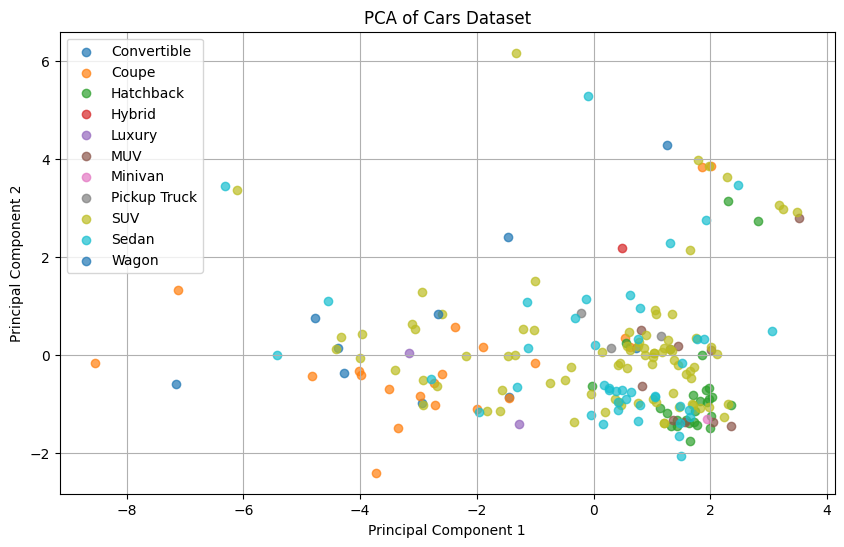

In [14]:
plt.figure(figsize=(10,6))
for c in np.unique(classes):
    plt.scatter(X_pca[classes == c, 0], X_pca[classes == c, 1], label=c, alpha=0.7)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Cars Dataset")
plt.legend()
plt.grid(True)
plt.show()

Plot each car in PC1–PC2 space.

Color points by body_type to reveal clusters (SUVs, Sedans, Sports Cars, etc.).

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


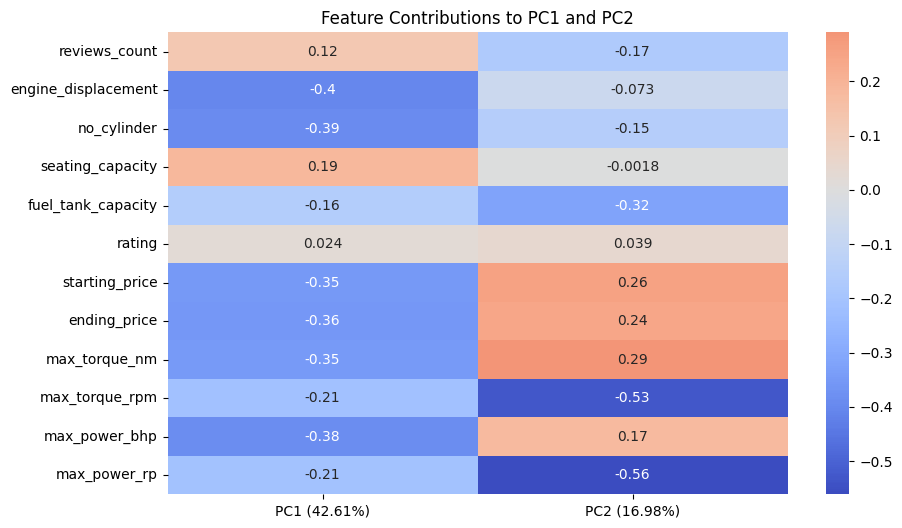

In [15]:
# Loadings = eigenvectors
loadings = pd.DataFrame(eigenvectors, 
                        index=features, 
                        columns=[f"PC{i+1}" for i in range(len(eigenvectors))])

pc_labels = [f"PC1 ({explained_variance_ratio[0]:.2%})",
             f"PC2 ({explained_variance_ratio[1]:.2%})"]

plt.figure(figsize=(10,6))
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap="coolwarm", center=0,
            xticklabels=pc_labels)
plt.title("Feature Contributions to PC1 and PC2")
plt.show()


a heatmap of feature loadings.

Each cell shows how much a feature contributes to PC1 or PC2.

Example: If horsepower and torque dominate PC1, it likely represents engine power.